# Phosphofructokinase (PFK)
To construct the phosphofructokinase module, first we import **MASSpy** and other essential packages. Constants used throughout the notebook are also defined.

In [1]:
from operator import attrgetter
from os import path

import matplotlib.pyplot as plt

import numpy as np

from scipy import optimize

import sympy as sym

from cobra import DictList

from mass import MassMetabolite, Simulation, UnitDefinition
from mass.enzyme_modules import EnzymeModule
from mass.io import json, sbml
from mass.util.expressions import Keq2k, k2Keq, strip_time
from mass.util.matrix import matrix_rank
from mass.util.qcqa import qcqa_model

Note that the total enzyme concentration of PFK is \\(33 nM = 0.033 \mu M = 0.000033 mM\\).

For the construction of the `EnzymeModule` for PFK, the following assumptions were made:

1. The enzyme is a homotetramer.
2. The enzyme binding and catalyzation of substrates occurs in an ordered sequential mechanism.
3. The mechanism of allosteric regulation is based on the Monod-Wyman-Changeux (MWC) model for allosteric transitions of homoproteins.

## Module Construction
The first step of creating the PFK module is to define the `EnzymeModule`. The `EnzymeModule` is an extension of the `MassModel`, with additional enzyme-specific attributes that aid in the construction, validation, and utilization of the module.

__Note:__ All `EnzymeModule` specific attributes start will start the prefix "enzyme" or "enzyme_module".

In [2]:
PFK = EnzymeModule("PFK", name="Phosphofructokinase", 
                   subsystem="Glycolysis")

Academic license - for non-commercial use only


### Metabolites
#### Ligands
The next step is to define all of the metabolites using the `MassMetabolite` object. For `EnzymeModule` objects, the `MassMetabolite` objects will be refered to as ligands, for these `MassMetabolite` form a complex with the enzyme to serve some biological purpose. Some considerations for this step include the following:

1. It is important to use a clear and consistent format for identifiers and names when defining the `MassMetabolite` objects for various reasons, some of which include improvements to model clarity and utility, assurance of unique identifiers (required to add metabolites to the model), and consistency when collaborating and communicating with others. 


2. In order to ensure our model is physiologically accurate, it is important to provide the `formula` argument with a string representing the chemical formula for each metabolite, and the `charge` argument with an integer representing the metabolite's ionic charge (Note that neutrally charged metabolites are provided with 0). These attributes can always be set later if necessary using the `formula` and `charge` attribute setter methods.


3. To indicate that the cytosol is the cellular compartment in which the reactions occur, the string "c" is provided to the `compartment` argument.

This model will be created using identifiers and names found in the [BiGG Database](http://bigg.ucsd.edu/).

The ligands correspond to the activators, inhibitors, cofactors, substrates, and products involved in the enzyme catalyzed reaction. In this model, there are 6 species which must be considered.

In [3]:
f6p_c = MassMetabolite(
    "f6p_c",
    name="D-Fructose 6-phosphate",
    formula="C6H11O9P",
    charge=-2,
    compartment="c")
fdp_c = MassMetabolite(
    "fdp_c",
    name="D-Fructose 1,6-bisphosphate",
    formula="C6H10O12P2",
    charge=-4,
    compartment="c")
atp_c = MassMetabolite(
    "atp_c",
    name="ATP",
    formula="C10H12N5O13P3",
    charge=-4,
    compartment="c")
adp_c = MassMetabolite(
    "adp_c",
    name="ADP",
    formula="C10H12N5O10P2",
    charge=-3,
    compartment="c")
amp_c = MassMetabolite(
    "amp_c",
    name="AMP",
    formula="C10H12N5O7P",
    charge=-2,
    compartment="c")
h_c = MassMetabolite(
    "h_c",
    name="H+",
    formula="H",
    charge=1,
    compartment="c") 

After generating the ligands, they are added to the `EnzymeModule` through the `add_metabolites` method. The ligands of the `EnzymeModule` can be viewed as a `DictList` through the `enzyme_module_ligands` attribute.

In [4]:
# Add the metabolites to the EnzymeModule
PFK.add_metabolites([f6p_c, fdp_c, atp_c, adp_c, amp_c, h_c])
# Access DictList of ligands and print
print("All {0} Ligands: {1}\n".format(
    PFK.id, "; ".join([m.id for m in PFK.enzyme_module_ligands])))

All PFK Ligands: f6p_c; fdp_c; atp_c; adp_c; amp_c; h_c



The `enzyme_module_ligands_categorized` attribute can be used to assign metabolites to groups of user-defined categories by providing a dictionary where keys are the categories and values are the metabolites. Note that any metabolite can be placed in more than one category.

In [5]:
PFK.enzyme_module_ligands_categorized =  {
    "Substrates": f6p_c,
    "Cofactors": atp_c,
    "Activators": amp_c,
    "Inhibitors": atp_c,
    "Products": [fdp_c, adp_c, h_c]}

# Access DictList of ligands and print
print("All {0} ligands ({1} total):\n{2}\n".format(
    PFK.id, len(PFK.enzyme_module_ligands),
    str([m.id for m in PFK.enzyme_module_ligands])))

# Access categorized attribute for ligands and print
for group in PFK.enzyme_module_ligands_categorized:
    print("{0}: {1}".format(
        group.id, str([m.id for m in group.members])))

All PFK ligands (6 total):
['f6p_c', 'fdp_c', 'atp_c', 'adp_c', 'amp_c', 'h_c']

Substrates: ['f6p_c']
Cofactors: ['atp_c']
Activators: ['amp_c']
Inhibitors: ['atp_c']
Products: ['h_c', 'adp_c', 'fdp_c']


#### EnzymeModuleSpecies

The next step is to define the various states of the enzyme and enzyme-ligand complexes. These states can be represented through an `EnzymeModuleSpecies` object. Just like how `EnzymeModule` objects extend `MassModels`, the `EnzymeModuleSpecies` extend `MassMetabolite` objects, giving them the same functionality as a `MassMetabolite`. However, there are three important additional attrubutes that are specific to the `EnzymeModuleSpecies`.

* The first attribute is the `enzyme_module_id`. It is meant to hold the identifier or name of the `EnzymeModule` that the `EnzymeModuleSpecies` belongs to.
* The second and third attributes are the `bound_catalytic` and `bound_effectors` attributes, designed to contain metabolites bound to the active/catalytic site and effector metabolites bound to the enzyme, respectively. 
* Automatic generation of the `name`, `formula`, and `charge` attributes attributes utilize the `bound_catalytic` and `bound_effectors` attributes, which can aid in identification of `EnzymeModuleSpecies` and mass and charge balancing of the reactions.

The most convenient way to make an `EnzymeModuleSpecies` is through the `EnzymeModule.make_enzyme_module_species` method. There are several reasons to use this method to generate the `EnzymeModuleSpecies`:

1. The only requirement to creating an `EnzymeModuleSpecies` is an identifier.
2. A string can optionally be provided for the `name` argument to set the corresponding `name` attribute, or it can automatically be generated and set by setting the string "Automatic" (case sensitve). 
3. The `enzyme_module_id`, `formula` and `charge` attributes are set based on the identifier of the EnzymeModule and the MassMetabolite objects found in `bound_catalytic` and `bound_effectors`
4. Just like the `enzyme_module_ligands_categorized` attribute, there is the `enzyme_module_species_categorized` attribute that behaves in a similar manner. Categories can be set at the time of construction by providing a string or a list of strings to the `categories` argument. 
5. `EnzymeModuleSpecies` are automatically added to the `EnzymeModule` once created.

For this module, there are 20 `EnzymeModuleSpecies` that must be created. Because of the assumptions made for this module, a loop can be used to help automate the construction of the `EnzymeModuleSpecies`.

In [6]:
# Number of identical subunits
n_subunits = 4

for i in range(n_subunits + 1):
    # Make enzyme module species per number of bound activators (Up to 4 Total)
    PFK.make_enzyme_module_species(
        "pfk_R{0:d}_c".format(i), 
        name="Automatic", 
        categories=("Relaxed", "Free_Catalytic"),
        bound_catalytic={},
        bound_effectors={amp_c: i},
        compartment="c");

    PFK.make_enzyme_module_species(
        "pfk_R{0:d}_A_c".format(i), 
        name="Automatic", 
        categories=("Relaxed", "Complexed_ATP"),
        bound_catalytic={atp_c: 1},
        bound_effectors={amp_c: i},
        compartment="c");
    
    PFK.make_enzyme_module_species(
        "pfk_R{0:d}_AF_c".format(i), 
        name="Automatic", 
        categories=("Relaxed", "Complexed_ATP_F6P"),
        bound_catalytic={atp_c: 1, f6p_c: 1},
        bound_effectors={amp_c: i},
        compartment="c");

    # Make enzyme module species per number of bound inhibitors (Up to 4 Total)
    PFK.make_enzyme_module_species(
        "pfk_T{0:d}_c".format(i), 
        name="Automatic", 
        categories="Tense",
        bound_catalytic={},
        bound_effectors={atp_c: i},
        compartment="c");

# Access DictList of enzyme module species and print
print("All {0} enzyme module species ({1} total):\n{2}\n".format(
    PFK.id, len(PFK.enzyme_module_species),
    str([m.id for m in PFK.enzyme_module_species])))

# Access categorized attribute for enzyme module species and print
for group in PFK.enzyme_module_species_categorized:
    print("{0}: {1}\n".format(
        group.id, str(sorted([m.id for m in group.members]))))

All PFK enzyme module species (20 total):
['pfk_R0_c', 'pfk_R0_A_c', 'pfk_R0_AF_c', 'pfk_T0_c', 'pfk_R1_c', 'pfk_R1_A_c', 'pfk_R1_AF_c', 'pfk_T1_c', 'pfk_R2_c', 'pfk_R2_A_c', 'pfk_R2_AF_c', 'pfk_T2_c', 'pfk_R3_c', 'pfk_R3_A_c', 'pfk_R3_AF_c', 'pfk_T3_c', 'pfk_R4_c', 'pfk_R4_A_c', 'pfk_R4_AF_c', 'pfk_T4_c']

Relaxed: ['pfk_R0_AF_c', 'pfk_R0_A_c', 'pfk_R0_c', 'pfk_R1_AF_c', 'pfk_R1_A_c', 'pfk_R1_c', 'pfk_R2_AF_c', 'pfk_R2_A_c', 'pfk_R2_c', 'pfk_R3_AF_c', 'pfk_R3_A_c', 'pfk_R3_c', 'pfk_R4_AF_c', 'pfk_R4_A_c', 'pfk_R4_c']

Free_Catalytic: ['pfk_R0_c', 'pfk_R1_c', 'pfk_R2_c', 'pfk_R3_c', 'pfk_R4_c']

Complexed_ATP: ['pfk_R0_A_c', 'pfk_R1_A_c', 'pfk_R2_A_c', 'pfk_R3_A_c', 'pfk_R4_A_c']

Complexed_ATP_F6P: ['pfk_R0_AF_c', 'pfk_R1_AF_c', 'pfk_R2_AF_c', 'pfk_R3_AF_c', 'pfk_R4_AF_c']

Tense: ['pfk_T0_c', 'pfk_T1_c', 'pfk_T2_c', 'pfk_T3_c', 'pfk_T4_c']



## Reactions
### EnzymeModuleReactions
Once all of the `MassMetabolite` objects and `EnzymeModuleSpecies` have been created, the next step is to define all of the enzyme-ligand binding reactions and conformation trasitions that occur in its mechanism.

These reactions can be represented through an `EnzymeModuleReaction` object. As with the previous enzyme objects,  `EnzymeModuleReactions` extend `MassReaction` objects to maintain the same functionality. However, as with the `EnzymeModuleSpecies`, the `EnzymeModuleReaction` has additional enzyme-specific attributes, such as the `enzyme_module_id`.

The most conveient way to make an `EnzymeModuleReaction` is through the `EnzymeModule.make_enzyme_module_reaction` method. There are several reasons to use this method to generate the EnzymeModuleReactions:

1. The only requirement to creating an `EnzymeModuleReaction` is an identifier.
2. A string can optionally be provided for the `name` argument to set the corresponding `name` attribute, or it can automatically be generated and set by setting the string "Automatic" (case sensitve). 
3. There is an `enzyme_module_reactions_categorized` attribute that behaves in a similar manner as the previous categorized attributes. Categories can be set at the time of construction by providing a string or a list of strings to the `categories` argument. 
4. `MassMetabolite` objects and `EnzymeModuleSpecies` that already exist in the `EnzymeModule` can be directly added to the newly created `EnzymeModuleReaction` by providing a dictionary to the optional `metabolites_to_add` argument using string identifiers (or the objects) as keys and their stoichiometric coefficients as the values.
5. `EnzymeModuleReactions` are automatically added to the `EnzymeModule` once created.

For this module, there are 24 `EnzymeModuleReactions` that must be created. Because of the assumptions made for this module, a loop can be used to help automate the construction of the `EnzymeModuleReactions`.

In [7]:
for i in range(n_subunits + 1):
    # Make reactions for enzyme-ligand binding and catalytzation per number of bound activators (Up to 4 Total)
    PFK.make_enzyme_module_reaction(
        "PFK_R{0:d}1".format(i), 
        name="Automatic",
        subsystem="Glycolysis",
        reversible=True,
        categories="atp_c_binding",
        metabolites_to_add={
            "pfk_R{0:d}_c".format(i): -1, 
            "atp_c": -1, 
            "pfk_R{0:d}_A_c".format(i): 1})
    
    PFK.make_enzyme_module_reaction(
        "PFK_R{0:d}2".format(i), 
        name="Automatic",
        subsystem="Glycolysis",
        reversible=True,
        categories="f6p_c_binding",
        metabolites_to_add={
            "pfk_R{0:d}_A_c".format(i): -1, 
            "f6p_c": -1, 
            "pfk_R{0:d}_AF_c".format(i): 1})
    
    PFK.make_enzyme_module_reaction(
        "PFK_R{0:d}3".format(i), 
        name="Automatic",
        subsystem="Glycolysis",
        reversible=False,
        categories="catalyzation",
        metabolites_to_add={
            "pfk_R{0:d}_AF_c".format(i): -1, 
            "pfk_R{0:d}_c".format(i): 1, 
            "adp_c": 1, 
            "fdp_c": 1,
            "h_c": 1})
    
    if i < n_subunits:
        # Make enzyme reactions for enzyme-activator binding
        PFK.make_enzyme_module_reaction(
            "PFK_R{0:d}0".format(i + 1), 
            name="Automatic",
            subsystem="Glycolysis",
            reversible=True,
            categories="amp_c_activation",
            metabolites_to_add={
                "pfk_R{0:d}_c".format(i): -1, 
                "amp_c": -1, 
                "pfk_R{0:d}_c".format(i + 1): 1})

        # Make enzyme reactions for enzyme-inhibitor binding
        PFK.make_enzyme_module_reaction(
            "PFK_T{0:d}".format(i + 1), 
            name="Automatic",
            subsystem="Glycolysis",
            reversible=True,
            categories="atp_c_inhibition",
            metabolites_to_add={
                "pfk_T{0:d}_c".format(i): -1, 
                "atp_c": -1, 
                "pfk_T{0:d}_c".format(i + 1): 1})

# Make reaction representing enzyme transition from R to T state
PFK.make_enzyme_module_reaction(
    "PFK_L",
    name="Automatic",
    subsystem="Glycolysis",
    reversible=True,
    categories="RT_transition",
    metabolites_to_add={
        "pfk_R0_c": -1, 
        "pfk_T0_c": 1})

# Access DictList of enzyme module reactions and print
print("All {0} enzyme module reactions ({1} total):\n{2}\n".format(
    PFK.id, len(PFK.enzyme_module_reactions),
    str([m.name for m in PFK.enzyme_module_reactions])))

# Access categorized attribute for enzyme module reactions and print
for group in PFK.enzyme_module_reactions_categorized:
    print("{0}: {1}\n".format(
        group.id, str(sorted([m.id for m in group.members]))))

All PFK enzyme module reactions (24 total):
['pfk_R0-atp binding', 'pfk_R0_A-f6p binding', 'pfk_R0_AF catalyzation', 'pfk_R0-amp binding', 'pfk_T0-atp binding', 'pfk_R1-atp binding', 'pfk_R1_A-f6p binding', 'pfk_R1_AF catalyzation', 'pfk_R1-amp binding', 'pfk_T1-atp binding', 'pfk_R2-atp binding', 'pfk_R2_A-f6p binding', 'pfk_R2_AF catalyzation', 'pfk_R2-amp binding', 'pfk_T2-atp binding', 'pfk_R3-atp binding', 'pfk_R3_A-f6p binding', 'pfk_R3_AF catalyzation', 'pfk_R3-amp binding', 'pfk_T3-atp binding', 'pfk_R4-atp binding', 'pfk_R4_A-f6p binding', 'pfk_R4_AF catalyzation', 'pfk_R0-pfk_T0 transition']

atp_c_binding: ['PFK_R01', 'PFK_R11', 'PFK_R21', 'PFK_R31', 'PFK_R41']

f6p_c_binding: ['PFK_R02', 'PFK_R12', 'PFK_R22', 'PFK_R32', 'PFK_R42']

catalyzation: ['PFK_R03', 'PFK_R13', 'PFK_R23', 'PFK_R33', 'PFK_R43']

amp_c_activation: ['PFK_R10', 'PFK_R20', 'PFK_R30', 'PFK_R40']

atp_c_inhibition: ['PFK_T1', 'PFK_T2', 'PFK_T3', 'PFK_T4']

RT_transition: ['PFK_L']



### Create and  Unify Rate Parameters
The next step is to unify rate parameters of binding steps that are not unique, allowing for those parameter values to be defined once and stored in the same place. Therefore, custom rate laws with custom parameters are used to reduce the number of parameters that need to be defined and better represent the module.

The rate law parameters can be unified using the `EnzymeModule.unify_rate_parameters` class method. This method requires a list of reactions whose rate laws that should be identical, along with a string representation of the new identifier to use on the unified parameters. There is also the optional `prefix ` argument, which if set to True, will ensure the new parameter identifiers are prefixed with the `EnzymeModule` identifier. This can be used to help prevent custom parameters from being replaced when multiple models are merged.

#### Allosteric Transitions: Symmetry Model

Once rate parameters are unified, the allosteric regulation of this enzyme must be accounted for. Because this module is to be based on the (Monod-Wyman-Changeux) MWC model for ligand binding and allosteric regulation, the rate laws of the allosteric binding reactions must be adjusted to reflect the symmetry in the module using the number of identical binding sites to help determine the scalars for the parameters. 

For this module, PFK is considered a homotetramer, meaning it has four identical subunits \\(\nu = 4\\). Each subunit can be allosterically activated by AMP or inhibited by ATP. The helper functions `k2Keq`, `Keq2k`, and `strip_time` from the `mass.util` submodule will be used to help facilitate the rate law changes in this example so that the final rate laws are dependent on the forward rate (kf) and equilibrium (Keq) constants.

In [8]:
abbreviations = ["A", "F", "I", "ACT"]
ligands = [atp_c, f6p_c, atp_c, amp_c]

for met, unified_id in zip(ligands, abbreviations):
    category = {"A": "binding",
                "F": "binding",
                "I": "inhibition",
                "ACT": "activation"}[unified_id]
    group = PFK.enzyme_module_reactions_categorized.get_by_id(
        "_".join((met.id, category)))
    reactions = sorted(group.members, key=attrgetter("id"))
    PFK.unify_rate_parameters(reactions, unified_id,
                              rate_type=2, enzyme_prefix=True)
    # Add the coefficients to make symmetry model rate laws for activation and inhibition 
    if unified_id in ["I", "ACT"]:
        for i, reaction in enumerate(reactions):
            custom_rate = str(strip_time((reaction.rate)))
            custom_rate = custom_rate.replace(
                "kf_", "{0:d}*kf_".format(n_subunits - i))
            custom_rate = custom_rate.replace(
                "kr_", "{0:d}*kr_".format(i + 1))
            PFK.add_custom_rate(reaction, custom_rate)
            
PFK.unify_rate_parameters(
    PFK.enzyme_module_reactions_categorized.get_by_id("catalyzation").members,
    "PFK")
# Update rate laws to be in terms of kf and Keq
PFK.custom_rates.update(k2Keq(PFK.custom_rates))

# Access categorized attribute for enzyme module reactions and print
for group in PFK.enzyme_module_reactions_categorized:
    header = "Category: " + group.id
    print("\n" + header + "\n" + "-" * len(header))
    for reaction in sorted(group.members, key=attrgetter("id")):
        print(reaction.id + ": " + str(reaction.rate))


Category: atp_c_binding
-----------------------
PFK_R01: kf_PFK_A*(atp_c(t)*pfk_R0_c(t) - pfk_R0_A_c(t)/Keq_PFK_A)
PFK_R11: kf_PFK_A*(atp_c(t)*pfk_R1_c(t) - pfk_R1_A_c(t)/Keq_PFK_A)
PFK_R21: kf_PFK_A*(atp_c(t)*pfk_R2_c(t) - pfk_R2_A_c(t)/Keq_PFK_A)
PFK_R31: kf_PFK_A*(atp_c(t)*pfk_R3_c(t) - pfk_R3_A_c(t)/Keq_PFK_A)
PFK_R41: kf_PFK_A*(atp_c(t)*pfk_R4_c(t) - pfk_R4_A_c(t)/Keq_PFK_A)

Category: f6p_c_binding
-----------------------
PFK_R02: kf_PFK_F*(f6p_c(t)*pfk_R0_A_c(t) - pfk_R0_AF_c(t)/Keq_PFK_F)
PFK_R12: kf_PFK_F*(f6p_c(t)*pfk_R1_A_c(t) - pfk_R1_AF_c(t)/Keq_PFK_F)
PFK_R22: kf_PFK_F*(f6p_c(t)*pfk_R2_A_c(t) - pfk_R2_AF_c(t)/Keq_PFK_F)
PFK_R32: kf_PFK_F*(f6p_c(t)*pfk_R3_A_c(t) - pfk_R3_AF_c(t)/Keq_PFK_F)
PFK_R42: kf_PFK_F*(f6p_c(t)*pfk_R4_A_c(t) - pfk_R4_AF_c(t)/Keq_PFK_F)

Category: catalyzation
----------------------
PFK_R03: kf_PFK*pfk_R0_AF_c(t)
PFK_R13: kf_PFK*pfk_R1_AF_c(t)
PFK_R23: kf_PFK*pfk_R2_AF_c(t)
PFK_R33: kf_PFK*pfk_R3_AF_c(t)
PFK_R43: kf_PFK*pfk_R4_AF_c(t)

Category: amp_

## The Steady State
### Solve steady state concentrations symbolically
To determine the steady state of the enzyme, a dictionary of the ordinary differential equations as symbolic expressions for each of the `EnzymeModuleSpecies`. The ligands are first removed from the equations by assuming their values are taken into account in a lumped rate constant parameter.

For handling of all symbolic expressions, the **sympy** package is used.

In [9]:
# Make a dictionary of ODEs and lump ligands into rate parameters by giving them a value of 1
ode_dict = {}
lump_ligands = {sym.Symbol(met.id): 1 for met in PFK.enzyme_module_ligands}
for enzyme_module_species in PFK.enzyme_module_species:
    symbol_key = sym.Symbol(enzyme_module_species.id)
    ode = sym.Eq(strip_time(enzyme_module_species.ode))
    ode_dict[symbol_key] = ode.subs(lump_ligands)

rank = matrix_rank(PFK.S[6:])
print("Rank Deficiency: {0}".format(len(ode_dict) - rank))

Rank Deficiency: 1


In order to solve the system of ODEs for the steady state concentrations, an additional equation is required due to the rank deficiency of the stoichiometric matrix. Therefore, the equation for the steady state flux through the enzyme, which will be referred to as the "enzyme net flux equation", must be defined. 

To define the enzyme net flux equation, the `EnzymeModule.make_enzyme_netflux_equation` class method can be used. 

* This equation is made by providing a reaction, or a list of reactions to add together.
* Passing a bool to `use_rates` argument determines whether a symbolic equation is a summation of the flux symbols returned by `EnzymeModuleReaction.flux_symbol_str`, or a summation of the rates laws for those reactions.
* The `update_enzyme` argument determines whether the new rate equation is set in the `enzyme_net_flux_equation` attribute.

The flux through the enzyme typically corresponds to the sum of the fluxes through the catalytic reaction steps.
Because the catalyzation reactions were assigned to the "catalyzation" cateogry, they can be accessed through the `enzyme_module_reactions_categorized` attribute to create the equation for \\(v_{\mathrm{PFK}}\\).

In [10]:
reactions = PFK.enzyme_module_reactions_categorized.get_by_id(
    "catalyzation").members
PFK.make_enzyme_net_flux_equation(
    reactions,
    use_rates=True, update_enzyme=True)
sym.pprint(PFK.enzyme_net_flux_equation)

v_PFK = kf_PFK⋅(pfk_R0_AF_c(t) + pfk_R1_AF_c(t) + pfk_R2_AF_c(t) + pfk_R3_AF_c
(t) + pfk_R4_AF_c(t))


The next step is to identify equations for the unknown concentrations in each reaction. These equations will need to be solved with a dependent variable before accounting for the enzyme net flux equation. The completely free form of the enzyme with no bound species will be treated as the dependent variable. 

To verify that all equations are in terms of the lumped rate parameters, and the dependent variable, the solutions can be iterated through using the atoms method to identify the equation arguments. 

There should be no `EnzymeModuleSpecies` identifiers with the exception of the dependent variable. 

In [11]:
# Get enzyme module species
enzyme_module_species = PFK.enzyme_module_species.copy()
# Reverse list for increased performance (due to symmetry assumption)
# by solving for the most activated/inhibitors bound first.
enzyme_module_species.reverse()

enzyme_solutions = {}
for enzyme_module_specie in enzyme_module_species:
    # Skip dependent variable
    if "pfk_R0_c" == str(enzyme_module_specie):
        continue
    enzyme_module_specie = sym.Symbol(enzyme_module_specie.id)
    # Susbtitute in previous solutions and solve for the enzyme module specie, 
    equation = ode_dict[enzyme_module_specie]
    sol = sym.solveset(equation.subs(enzyme_solutions), enzyme_module_specie)
    enzyme_solutions[enzyme_module_specie] = list(sol)[0]
    # Update the dictionary of solutions with the solutions
    enzyme_solutions.update({enzyme_module_specie: sol.subs(enzyme_solutions) 
                             for enzyme_module_specie, sol in enzyme_solutions.items()})
args = set()
for sol in enzyme_solutions.values():
    args.update(sol.atoms(sym.Symbol))
print(args)

{kf_PFK_F, Keq_PFK_A, Keq_PFK_I, Keq_PFK_ACT, pfk_R0_c, kf_PFK, Keq_PFK_L, kf_PFK_A, Keq_PFK_F}


The enzyme net flux equation can then be utilized as the last equation required to solve for the final unknown concentration variable in terms of the rate and equilibrium constants, allowing for all of the concentration variables to be defined in terms of the rate and equilibrium constants. Once the unknown variable has been solved for, the solution can be substituted back into the other equations. Because `sympy.solveset` function expects the input equations to be equal to 0, the `EnzymeModule.enzyme_net_flux_error` method with the `use_values`  argument set to False to get the appropriate expression.

In [12]:
enzyme_net_flux_equation = strip_time(PFK.enzyme_net_flux_error(False))
print("Enzyme Net Flux Equation\n" + "-"*24)
sym.pprint(enzyme_net_flux_equation)

# Solve for last unknown concentration symbolically
sol = sym.solveset(enzyme_net_flux_equation.subs(enzyme_solutions), "pfk_R0_c")

# Update solution dictionary with the new solution
enzyme_solutions[sym.Symbol("pfk_R0_c")] = list(sol)[0]

# Update solutions with free variable solutions
enzyme_solutions = {
    enzyme_module_species: sym.simplify(solution.subs(enzyme_solutions))
    for enzyme_module_species, solution in enzyme_solutions.items()}

args = set()
for sol in enzyme_solutions.values():
    args.update(sol.atoms(sym.Symbol))
print("\n", args)

Enzyme Net Flux Equation
------------------------
-kf_PFK⋅(pfk_R0_AF_c + pfk_R1_AF_c + pfk_R2_AF_c + pfk_R3_AF_c + pfk_R4_AF_c) 
+ v_PFK

 {kf_PFK_F, Keq_PFK_A, Keq_PFK_I, Keq_PFK_ACT, kf_PFK, Keq_PFK_L, kf_PFK_A, Keq_PFK_F, v_PFK}


#### Numerical Values
At this point, numerical values are defined for the dissociation constants and the concentrations of the substrates, cofactors, activators, and inhibitors. Providing these numerical values will speed up the subsequent calculations. 

To do this, experimental data is used to define the dissociations constants for the different binding steps under the QEA. The concentrations of the non-enzyme species are taken from the glycolysis model. 

Experimental data gives the following for the dissociation constants: 

$$\\K_i=0.1 mM,\ K_a=0.033 mM,\ K_A=0.068 mM, K_F=0.1 mM,\ $$ and an allosteric constant of \\(K_L = 0.0011\\).


__Note:__ The \\(K_i\\) binding constant for ATP as an inhibitor was increased by a factor of ten since magnesium complexing of ATP is not considered here. 

In [13]:
numerical_values = {}

# Get ligand IDs and parameter IDs
ligand_ids = sorted([str(ligand) for ligand in PFK.enzyme_module_ligands])
parameter_ids = ["_".join((PFK.id, abbrev)) for abbrev in abbreviations + ["L"]]
print("Ligand IDs: " + str(ligand_ids))
print("Parameter IDs: " + str(parameter_ids))

# Load the glycolysis model to extract steady state values
glycolysis = json.load_json_model(
    path.realpath(path.join("models", "SB2_Glycolysis.json")))

# Get the steady state flux value and add to numerical values
PFK.enzyme_net_flux = glycolysis.reactions.get_by_id(PFK.id).steady_state_flux
numerical_values.update({PFK.enzyme_flux_symbol_str: PFK.enzyme_net_flux})

# Get the steady state concentration values and add to numerical values
initial_conditions = {
    str(ligand): glycolysis.initial_conditions[glycolysis.metabolites.get_by_id(ligand)]
    for ligand in ligand_ids}

# Define parameter values and add to numerical values
# Because of the QEA, invert dissociation constants for Keq
parameter_values = {
    "Keq_" + parameter_id: value 
    for parameter_id, value in zip(parameter_ids, [1/0.068, 1/0.1, 1/0.1, 1/0.033, 0.0011])}

# Display numerical values
print("\nNumerical Values\n----------------")
for k, v in numerical_values.items():
    print("{0} = {1}".format(k, v))

Ligand IDs: ['adp_c', 'amp_c', 'atp_c', 'f6p_c', 'fdp_c', 'h_c']
Parameter IDs: ['PFK_A', 'PFK_F', 'PFK_I', 'PFK_ACT', 'PFK_L']

Numerical Values
----------------
v_PFK = 1.12


The next step is to define the numerical values, \\(K_i=0.1/1.6\\), \\(K_a=0.033/0.0867\\), \\(K_A=0.068/1.6\\), \\(K_F=0.1/0.0198\\), \\(v_{PFK}=1.12 \text{mM/hr}\\), and \\(K_L=1/0.0011\\) using the dissociation constant values and the steady state concentrations of the ligands and introduce them into the solution to get the steady state concentrations of the enzyme module species in terms of the rate constants. The values of the equilirbium constants and initial conditions are also stored for later use.

In [14]:
# Match abbreviations to their corresponding ligands
abbreviation_dict = {"PFK_A": "atp_c", "PFK_F": "f6p_c", "PFK_ACT": "amp_c", "PFK_I": "atp_c", "PFK_L": ""}

k2K = {sym.Symbol("kr_" + p): sym.Symbol("kf_" + p)*sym.Symbol("K_" + p) for p in abbreviation_dict.keys()}
enzyme_solutions = {met: sym.simplify(Keq2k(solution).subs(enzyme_solutions).subs(k2K))
                    for met, solution in enzyme_solutions.items()}
K_values = dict(zip(["K_" + p for p in abbreviation_dict], [0.068, 0.1, 0.033, 0.1, 0.0011]))

for abbrev, ligand_id in abbreviation_dict.items():
    K_str = "K_" + abbrev
    if ligand_id:
        numerical_value = K_values[K_str]/initial_conditions[ligand_id]
    else:
        numerical_value = 1/K_values[K_str]
    numerical_values[sym.Symbol(K_str)] = numerical_value
    
enzyme_solutions = {met: sym.simplify(solution.subs(numerical_values))
                    for met, solution in enzyme_solutions.items()}

# Display numerical values
print("\nNumerical Values\n----------------")
for k, v in numerical_values.items():
    print("{0} = {1}".format(k, v))


Numerical Values
----------------
v_PFK = 1.12
K_PFK_A = 0.0425
K_PFK_F = 5.05050505050505
K_PFK_ACT = 0.3804995151513754
K_PFK_I = 0.0625
K_PFK_L = 909.090909090909


The last part of this step is to simplify the solutions for the enzyme module species and, as a QA check, ensure that only rate constants are the only symbolic arguments in the solutions. 

In [15]:
# Substitute values into equations
enzyme_solutions = {
    enzyme_module_species: sym.simplify(solution.subs(numerical_values))
    for enzyme_module_species, solution in enzyme_solutions.items()}

args = set()
for sol in enzyme_solutions.values():
    args.update(sol.atoms(sym.Symbol))
print(args)

{kf_PFK_A, kf_PFK_F, kf_PFK}


### Determine rate constants
#### Total Enzyme Concentration and $r_{T}$ 
After solving for the enzyme module species, the next step is to define equations for the total enzyme concentration and for the fraction of the enzyme in the T state. These two equations can be used as constraints for determining the rate parameters. To view the equation for the total enzyme concentration, we can use the `EnzymeModule.enzyme_concentration_total_equation` property.

In [16]:
sym.pprint(PFK.enzyme_concentration_total_equation)

PFK_Total = pfk_R0_AF_c(t) + pfk_R0_A_c(t) + pfk_R0_c(t) + pfk_R1_AF_c(t) + pf
k_R1_A_c(t) + pfk_R1_c(t) + pfk_R2_AF_c(t) + pfk_R2_A_c(t) + pfk_R2_c(t) + pfk
_R3_AF_c(t) + pfk_R3_A_c(t) + pfk_R3_c(t) + pfk_R4_AF_c(t) + pfk_R4_A_c(t) + p
fk_R4_c(t) + pfk_T0_c(t) + pfk_T1_c(t) + pfk_T2_c(t) + pfk_T3_c(t) + pfk_T4_c(
t)


The total concentration of PFK is 33 nM (=0.000033 mM). The `EnzymeModule.enzyme_concentration_total` atrribute can be used to set and store this concentration.

In [17]:
PFK.enzyme_concentration_total = 33e-6
print(PFK.enzyme_concentration_total)

3.3e-05


To determine the rate constants, an optimization problem where the objective function is to minimize the error between the measured and calculated total enzyme concentrations. To create the objective function, the `EnzymeModule.enzyme_concentration_total_error` method with the `use_values` argument set as False to get the symbolic expression of the constraint. 

In [18]:
enzyme_total_constraint = abs(strip_time(PFK.enzyme_concentration_total_error(use_values=False)))
sym.pprint(enzyme_total_constraint)

│-PFK_Total + pfk_R0_AF_c + pfk_R0_A_c + pfk_R0_c + pfk_R1_AF_c + pfk_R1_A_c +
 pfk_R1_c + pfk_R2_AF_c + pfk_R2_A_c + pfk_R2_c + pfk_R3_AF_c + pfk_R3_A_c + p
fk_R3_c + pfk_R4_AF_c + pfk_R4_A_c + pfk_R4_c + pfk_T0_c + pfk_T1_c + pfk_T2_c
 + pfk_T3_c + pfk_T4_c│


Substitute the solutions for the enzyme forms to get an equation for the error in the enzyme total concentration in terms of the rate constants.

In [19]:
# Substitute value for enzyme concentration total
enzyme_total_constraint = enzyme_total_constraint.subs({PFK.enzyme_total_symbol_str: PFK.enzyme_concentration_total})
# Substitute solutions into constraint and simplify
enzyme_total_constraint = sym.simplify(enzyme_total_constraint.subs(enzyme_solutions))
sym.pprint(enzyme_total_constraint)

│          1.19283868483391   1.71385140785683   7.14443780219149│
│-3.3e-5 + ──────────────── + ──────────────── + ────────────────│
│              kf_PFK_F           kf_PFK_A            kf_PFK     │


To create the objective function in a format suitable for the minimization method from the `scipy.optimize` submodule, the `sympy.lambdify` function can be used to convert the symbolic expression into a lambda function with the rate constants as the arguments. This lambda function can then be used to generate the objective function for the `optimize.minimize` method.

In [20]:
# Create a sorted tuple of the arguments to ensure the input format does not change
args = tuple(sorted([str(arg) for arg in list(args)]))
# Create the objective function as a lambda function
objective_function = lambda x: sym.lambdify(args, enzyme_total_constraint)(*x)

Another constraint can be set on the amount of inhibited enzyme in the steady state of the system using the T fraction (denoted as \\(r_{T}\\)). This fraction is simply the amount of inhibited enzyme over the total amount of enzyme. The enzyme is inhibited between 10-15% under physiological conditions (Ponce et al. Biochimica et Biophysica Acta 1971 250(1):63-74)

To make the fraction as a symbolic expression, we can use the `EnzymeModule.make_enzyme_fraction` method. This method is designed to assist in making fractions and ratios by passing to the function:
1. A string to the `categorized_attr` argument identifying which categorized attribute (either "species" for the `EnzymeModule.enzyme_module_species_categorized` or "reactions" for the `EnzymeModule.enzyme_module_reactions_categorized`).
2. A string for the `top` argument and a string for the `bottom` argument identifying the categories to sum and use in the numerator and the denominator, respectively.
3. A bool to the `use_values` argument indicating whether to substitute numerical values into the expression to return a float or to keep the ratio as a sympy expression.

__Note:__ The string "Equation" can be passed to either the `top` or `bottom` arguments to utilize the equation stored either in `enzyme_concentration_total_equation` (for `categorized_attr`="species"), or   `enzyme_net_flux_equation` (for `categorized_attr`="reactions").

In [21]:
# Set the values for the constraint bounds
r_T_lb, r_T_ub = (0.10, 0.15)
# Make a symbolic expression for enzyme fraction.
r_T_expr = PFK.make_enzyme_fraction(
    categorized_attr="species", top="Tense", bottom="Equation",
    use_values=False)
# Substitute solutions into the expression to make
# solely dependent on the rate constants
r_T_expr = sym.simplify(strip_time(r_T_expr).subs(enzyme_solutions))

# Make lambda functions for the T fraction constraint
r_T_lb_constraint = lambda x: sym.lambdify(args, r_T_expr - r_T_lb)(*x)
r_T_ub_constraint = lambda x: sym.lambdify(args, r_T_ub - r_T_expr)(*x)

Lastly, we place lower and upper bounds on the rate constants to ensure that the values are non-negative and are within physiological limits, and then we solve the optmization problem. Once the optimization has finished, we check whether it was successful, and if so, what the optimality and errors are associated with this particular solution instance.

In [22]:
print("Ordered Args: {0}\n".format(str(args)))
# Set arguments for minimization
kf_bounds = ((1e2, 1e8), (1e2, 1e8), (1e2, 1e8))
initial_guess = [
    3.07e5,
    2e5,
    1e6,]

# Find a feasible solution
sol = optimize.minimize(
    objective_function, x0=initial_guess,
    method="trust-constr",
    bounds=kf_bounds,
    options={"gtol": 1e-20, "xtol": 1e-20, "maxiter": 1e4, "disp": True})

# Check whether optimzation was successful
print("\nOptimization Success: {0}".format(sol.success))
if sol.success:
    # Update the paramter values dictionary with the feasible solution
    parameter_values.update(dict(zip(args, [round(x) for x in sol.x])))
    print("Optimization Optimality: {0:.4e}".format(sol.optimality))
    print("Parameter Solutions: {:}".format(str({arg: parameter_values[arg] for arg in args})))
    # Plug solutions back into constraints for validation
    print("Optimization Error: {0:.4e}".format(enzyme_total_constraint.subs(parameter_values)))

Ordered Args: ('kf_PFK', 'kf_PFK_A', 'kf_PFK_F')

`xtol` termination condition is satisfied.
Number of iterations: 104, function evaluations: 224, CG iterations: 116, optimality: 3.60e-11, constraint violation: 0.00e+00, execution time: 0.97 s.

Optimization Success: True
Optimization Optimality: 3.6029e-11
Parameter Solutions: {'kf_PFK': 307263.0, 'kf_PFK_A': 200325.0, 'kf_PFK_F': 1000059.0}
Optimization Error: 1.2079e-11


With a successful optimization, the module is updated with the parameter values.  The inhibition and activation reactions are set to have a high forward rate constant and the allosteric transition even higher, limiting the amount of unbound enzyme and ensuring that the dynamics are determined by the dissociation and allosteric constants. 

__Note:__ This assumption for the rate constants can be made because none of the enzyme concentrations are dependendent on the activation, inhibition, and allosteric rate constants.

In [23]:
# Add the activation, inhibition, and allosteric rate constants
for abbrev, value in zip(["I", "ACT", "L"], [1e6, 1e6, 1e6**2]):
    # Account for the enzyme prefix if used in the previous function
    to_join = ("kf", PFK.id, abbrev)
    param = "_".join(to_join)
    parameter_values.update({param: value})

# Display numerical values
for k, v in parameter_values.items():
    print("{0} = {1}".format(k, v))

Keq_PFK_A = 14.705882352941176
Keq_PFK_F = 10.0
Keq_PFK_I = 10.0
Keq_PFK_ACT = 30.3030303030303
Keq_PFK_L = 0.0011
kf_PFK = 307263.0
kf_PFK_A = 200325.0
kf_PFK_F = 1000059.0
kf_PFK_I = 1000000.0
kf_PFK_ACT = 1000000.0
kf_PFK_L = 1000000000000.0


### Solve steady state concentrations numerically

Once the rate constants have been defined, the steady state concentrations of the enzyme can be determined.

In [24]:
# Substitute values into equations
initial_conditions.update({
    str(enzyme_module_species): round(float(sym.simplify(solution.subs(parameter_values))), 12)
    for enzyme_module_species, solution in enzyme_solutions.items()})

for header, dictlist in zip(["Ligand", "\nEnzyme"], [PFK.enzyme_module_ligands, PFK.enzyme_module_species]):
    header += " Concentrations"
    print("\n".join([header, "-" * len(header)]))
    for species in dictlist:
        ic = initial_conditions[species.id]
        print("{0} = {1}".format(species.id, ic))

Ligand Concentrations
---------------------
f6p_c = 0.0198
fdp_c = 0.0146
atp_c = 1.6
adp_c = 0.29
amp_c = 0.0867281
h_c = 8.99757e-05

Enzyme Concentrations
----------------------
pfk_R0_c = 3.7057e-08
pfk_R0_A_c = 1.1271e-07
pfk_R0_AF_c = 2.1037e-08
pfk_T0_c = 4.1e-11
pfk_R1_c = 3.8956e-07
pfk_R1_A_c = 1.184861e-06
pfk_R1_AF_c = 2.21149e-07
pfk_T1_c = 2.609e-09
pfk_R2_c = 1.535718e-06
pfk_R2_A_c = 4.670944e-06
pfk_R2_AF_c = 8.71811e-07
pfk_T2_c = 6.2611e-08
pfk_R3_c = 2.690705e-06
pfk_R3_A_c = 8.18388e-06
pfk_R3_AF_c = 1.527485e-06
pfk_T3_c = 6.67853e-07
pfk_R4_c = 1.767877e-06
pfk_R4_A_c = 5.377063e-06
pfk_R4_AF_c = 1.003605e-06
pfk_T4_c = 2.671413e-06


#### Set Initial Conditions and Parameters
Once the steady state concentrations have been determined, the initial conditions and parameters are added to the module. All custom parameter are added to the custom_parameter attribute. The allosteric transition uses the standard parameter identifiers (returned by `kf_str` and `Keq_str` properties of the `EnzymeModuleReaction`), so they are popped out of the custom parameters and set through their respective attribute setter methods. 

In [25]:
# Set initial conditions
for met, concentration in initial_conditions.items():
    PFK.metabolites.get_by_id(str(met)).ic = concentration

# Add the custom parameters and values for kf and Keq to model
PFK.custom_parameters.update(parameter_values)
# PYK_L uses standard reaction parameters and not custom parameters
PFK_L = PFK.enzyme_module_reactions.PFK_L
PFK_L.kf = PFK.custom_parameters.pop(PFK_L.kf_str)
PFK_L.Keq = PFK.custom_parameters.pop(PFK_L.Keq_str)

#### Ordering of internal species and reactions

Sometimes, it is also desirable to reorder the metabolite and reaction objects inside the model to follow the physiology. To reorder the internal objects, one can use `cobra.DictList` containers and the `DictList.get_by_any` method with the list of object identifiers in the desirable order. To ensure all objects are still present and not forgotten in the model, a small QA check is also performed. 

In [26]:
new_metabolite_order = ['f6p_c', 'fdp_c', 'amp_c', 'adp_c', 'atp_c', 'h_c',
                        'pfk_R0_c', 'pfk_R0_A_c', 'pfk_R0_AF_c', 
                        'pfk_R1_c', 'pfk_R1_A_c', 'pfk_R1_AF_c', 
                        'pfk_R2_c', 'pfk_R2_A_c', 'pfk_R2_AF_c', 
                        'pfk_R3_c', 'pfk_R3_A_c', 'pfk_R3_AF_c',
                        'pfk_R4_c', 'pfk_R4_A_c', 'pfk_R4_AF_c',  
                        'pfk_T0_c','pfk_T1_c', 'pfk_T2_c', 'pfk_T3_c', 'pfk_T4_c']

if len(glycolysis.metabolites) == len(new_metabolite_order):
    PFK.metabolites = DictList(
        PFK.metabolites.get_by_any(new_metabolite_order))

if len(PFK.metabolites) == len(new_metabolite_order):
    PFK.metabolites = DictList(PFK.metabolites.get_by_any(new_metabolite_order))
    
new_reaction_order = ["PFK_R01", 'PFK_R02', "PFK_R03", "PFK_R10", 
                      "PFK_R11", "PFK_R12", "PFK_R13", "PFK_R20", 
                      "PFK_R21", "PFK_R22", "PFK_R23", "PFK_R30", 
                      "PFK_R31", "PFK_R32", "PFK_R33", "PFK_R40", 
                      "PFK_R41", "PFK_R42", "PFK_R43", "PFK_L", 
                      "PFK_T1", "PFK_T2", "PFK_T3", "PFK_T4"]

if len(PFK.reactions) == len(new_reaction_order):
    PFK.reactions = DictList(
        PFK.reactions.get_by_any(new_reaction_order))
    
PFK.update_S(array_type="DataFrame", dtype=int)

,PFK_R01,PFK_R02,PFK_R03,PFK_R10,PFK_R11,PFK_R12,PFK_R13,PFK_R20,PFK_R21,PFK_R22,...,PFK_R33,PFK_R40,PFK_R41,PFK_R42,PFK_R43,PFK_L,PFK_T1,PFK_T2,PFK_T3,PFK_T4
f6p_c,0,-1,0,0,0,-1,0,0,0,-1,...,0,0,0,-1,0,0,0,0,0,0
fdp_c,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
amp_c,0,0,0,-1,0,0,0,-1,0,0,...,0,-1,0,0,0,0,0,0,0,0
adp_c,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
atp_c,-1,0,0,0,-1,0,0,0,-1,0,...,0,0,-1,0,0,0,-1,-1,-1,-1
h_c,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
pfk_R0_c,-1,0,1,-1,0,0,0,0,0,0,...,0,0,0,0,0,-1,0,0,0,0
pfk_R0_A_c,1,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pfk_R0_AF_c,0,1,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pfk_R1_c,0,0,0,1,-1,0,1,-1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Module Validation 
### QC/QA model
Before saving the module, it is important to ensure that the module is elementally balanced, and that the module can be integrated into a larger network for simulation. Therefore, the `qcqa_model` function from `mass.util.qcqa`</td> is used to provide a report on the module quality and and indicate whether simulation is possible and if not, what parameters and/or initial conditions are missing. 

In [27]:
qcqa_model(PFK, parameters=True, concentrations=True, 
           fluxes=False, superfluous=True, elemental=True)

╒════════════════════════════════╕
│ MODEL ID: PFK                  │
│ SIMULATABLE: True;             │
│ NUMERICALLY CONSISTENT: True   │
╞════════════════════════════════╡
╘════════════════════════════════╛


### Constraint Satisfaction and Error Values
Another QA check we perform is to substitute the steady state numerical values back into the constraints used in determining the rate constants in order to ensure that the constraints remain satisified, and that errors are small. 

In [28]:
t_fraction = PFK.make_enzyme_fraction("species", top="Tense",
                                      bottom="Equation", use_values=True)
print("Enzyme T-fraction: {:.4f}".format(t_fraction))

print("Concentration Absolute Error: {0:.4e}".format(
    abs(PFK.enzyme_concentration_total_error(use_values=True))))
print("Flux Absolute Error: {0:.4e}".format(
    abs(PFK.enzyme_net_flux_error(use_values=True))))

Enzyme T-fraction: 0.1032
Concentration Absolute Error: 1.1000e-11
Flux Absolute Error: 3.6688e-07


### Add Enzyme to MassModel
In order to determine whether the module can be successfully integrated into a model, another model can be loaded, merged with the module, and simulated. To validate this module, it will be merged with a glycolysis model. 

To integrate the `EnzymeModule` into the `MassModel`, the reaction that the EnzymeModule will be replacing is first removed. The `MassModel.merge` method can then be utilized to add the `EnzymeModule` to the `MassModel`. 

When merging an `EnzymeModule` and a `MassModel`, the `EnzymeModule` should always be merged into the `MassModel`.

In [29]:
# Load and merge glycolysis and hemoglobin models
glycolysis = json.load_json_model(path.realpath(path.join("models", "SB2_Glycolysis.json")))
# Remove the PFK MassReaction, then merge the EnzymeModule into the MassModel
glycolysis.remove_reactions([glycolysis.reactions.get_by_id("PFK")])
glycolysis_PFK = glycolysis.merge(PFK)
glycolysis_PFK

Name,Glycolysis
Memory address,0x0125e4f5f8
Stoichiometric Matrix,40x44
Matrix Rank,37
Number of metabolites,40
Initial conditions defined,40/40
Number of reactions,44
Number of genes,0
Number of enzyme modules,1
Number of groups,16
Objective expression,0


Using `MassModel.merge` class method enables the `EnzymeModule` and `MassModel` to be merged like as if they were both `MassModel` objects. However, all attributes specific to the `EnzymeModule` (e.g the categorized attributes) are condensed into a speciailzed container called an `EnzymeModuleDict`.

The `EnzymeModuleDict` behaves like an ordered dictionary, but is unique in that its contents can be accessed as if they were attributes. These attributes can be viewed using `EnzymeModuleDict.keys` method.

All `EnzymeModuleDicts` associated with a `MassModel` can be accessed via `MassModel.enzyme_modules` attribute.

In [30]:
print(str(glycolysis_PFK.enzyme_modules) + "\n")
print("Attribute Accessors:\n-------------------\n" + "\n".join(list(
    glycolysis_PFK.enzyme_modules.PFK.keys())) + "\n")
glycolysis_PFK.enzyme_modules.PFK

[<EnzymeModuleDict PFK at 0x125e63ea0>]

Attribute Accessors:
-------------------
id
name
subsystem
enzyme_module_ligands
enzyme_module_species
enzyme_module_reactions
enzyme_module_ligands_categorized
enzyme_module_species_categorized
enzyme_module_reactions_categorized
enzyme_concentration_total
enzyme_net_flux
enzyme_concentration_total_equation
enzyme_net_flux_equation
description
S
model



Name,PFK
Memory address,0x0125e63ea0
Stoichiometric Matrix,26x24
Matrix Rank,20
Subsystem,Glycolysis
Number of Ligands,6
Number of EnzymeForms,20
Number of EnzymeModuleReactions,24
Enzyme Concentration Total,3.3e-05
Enzyme Net Flux,1.12


### Validate Steady State

To find the steady state of the model and perform simulations, the model must first be loaded into a `Simulation`. In order to load a model into a `Simulation`, the model must be simulatable, meaning there are no missing numerical values that would prevent the integration of the ODEs that comprise the model. The `verbose` argument can be used while loading a model to produce a message indicating the successful loading of a model, or why a model could not load.

Once loaded into a `Simulation`, the `find_steady_state` method can be used with the `update_values` argument in order to update the initial conditions and fluxes of the model to a steady state. The model can then be simulated using the `simulate` method by passing the model to simulate, and a tuple containing the start time and the end time. The number of time points can also be included, but is optional.

After a successful simulation, two `MassSolution` objects are returned. The first `MassSolution` contains the concentration results of the simulation, and the second contains the flux results of the simulation. 

To visually validate the steady state of the model, concentration and flux solutions can be plotted using the `plot_time_profile` function from `mass.visualization`</td>. Alternatively, the `MassSolution.view_time_profile` property can be used to quickly generate a time profile for the results.

Successfully loaded MassModel 'Glycolysis' into RoadRunner.
Setting output selections
Setting simulation values for 'Glycolysis'
Getting time points
Simulating 'Glycolysis'
Found steady state for 'Glycolysis'.
Updating 'Glycolysis' values
Adding 'Glycolysis' simulation solutions to output


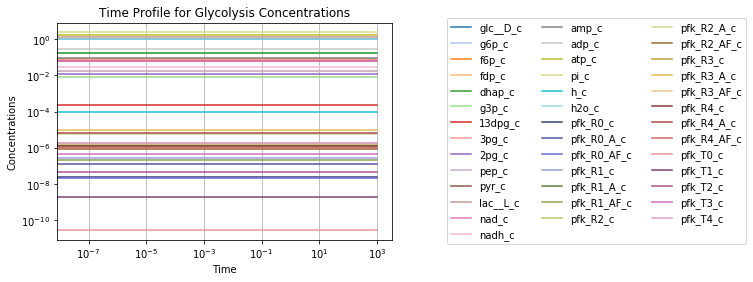

In [31]:
# Setup simulation object, ensure model is at steady state
sim = Simulation(glycolysis_PFK, verbose=True)
sim.find_steady_state(glycolysis_PFK, strategy="simulate",
                      update_values=True, verbose=True)

# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(
    glycolysis_PFK,time=(0, 1e3, 1e4 + 1))
# Quickly render and display time profiles
conc_sol.view_time_profile

### Storing information and references
#### Compartment
Because the character "c" represents the cytosol compartment, it is recommended to define and set the compartment in the `EnzymeModule.compartments` attribute.

In [32]:
PFK.compartments = {"c": "Cytosol"}
print(PFK.compartments)

{'c': 'Cytosol'}


#### Units
All of the units for the numerical values used in this model are "Millimoles" for amount and "Liters" for volume (giving a concentration unit of 'Millimolar'), and "Hours" for time. In order to ensure that future users understand the numerical values for model, it is important to define the `EnzymeModule.units` attribute.

The `EnzymeModule.units` is a `cobra.DictList` that contains only `UnitDefinition` objects from the `mass.core.unit` submodule. 

Each `UnitDefinition` is created from `Unit` objects representing the base units that comprise the `UnitDefinition`. These `Units` are stored in the `list_of_units` attribute. Pre-built units can be viewed using the `print_defined_unit_values` function from the `mass.core.unit`</td> submodule. Alternatively, custom units can also be created using the `UnitDefinition.create_unit` function.

For more information about units, please see the module docstring for `mass.core.unit` submodule.

__Note:__ It is important to note that this attribute will NOT track units, but instead acts as a reference for the user and others so that they can perform necessary unit conversions.

In [33]:
# Using pre-build units to define UnitDefinitions
concentration = UnitDefinition("mM", name="Millimolar", list_of_units=["millimole", "per_litre"])
time = UnitDefinition("hr", name="hour", list_of_units=["hour"])

# Add units to model
PFK.add_units([concentration, time])
print(PFK.units)

[<UnitDefinition Millimolar "mM" at 0x12a646be0>, <UnitDefinition hour "hr" at 0x12a646550>]


## Export

After validation, the model is ready to be saved. The model can either be exported as a ".json" file or as an ".sbml" (".xml") file using their repsective submodules in `mass.io`</td>.

To export the model, only the path to the directory and the name of the model need to be specified. Both are shown below. 

In [34]:
filepath = path.realpath(path.join("models", "SB2_" + PFK.id))

### Export using JSON

In [35]:
json.save_json_model(mass_model=PFK, filename=filepath + ".json")

### Export using SBML

In [36]:
sbml.write_sbml_model(mass_model=glycolysis_PFK, filename=filepath + ".xml")